# Prediction Challenge #

In this notebook the goal is to test a few different models for predicting the CLASE variable. The results are compared in the end and the best model is chosen. 

The first step as always is to import the necessary libraries and configure the settings of plots.

In [1]:
# Add the necessary libraries to use
import numpy as np
import pandas as pd

# Necessary commands for the graphs to show up in the notebook on the correct format
%matplotlib inline
import matplotlib.pyplot as plt

#matplotlib style options
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)

## 1. Read in data

The data used for the prediction challenge is the same dataset that was prepared in the "Descriptive Statics" and "Additional dataset" notebooks. It containes the provided housing dataset augmented with columns from the additional dataset relating to the number of Points of Interest in the area and the distance to the closest types of points of interest. The dataset contains 17.830 observations.

In [2]:
df = pd.read_csv("combined_data.csv")

In [3]:
len(df)

17830

## 2. Clean up outliers

Before the dataset was used as input in prediction models it was necessary to check if the dataset contained any outliers that could impact the performance of prediction models. Some machine learning models can be very sensitive to outliers and therefore it is always necessary to check and clean the data.

In this case the columns that were thought to contain outliers were collected into the **outlier_cols** list. These were selected based on the boxplots in the **Descriptive Statistics Notebook**.
Then for each column the z-score for each observation within that column was computed. The z-score indicates the number of standard deviations that the observation deviates from the mean of the observations of the columns. Here the cutoff is defined as 3 standard deviations, so if the observations deviates more greatly from the mean it is considered to be an outlier.

In [4]:
#all columns with outliers according to box plot
#outlier_cols = ['Acc_Servicios_tpte_pub', 'Acc_Comercio_auto', 'Acc_Educacion_auto' , 'Acc_Industria_auto',
#               'Acc_Servicios_auto','Acc_Habitacion_auto',
#                'Sup_Prom_Constr_Hab_EOD',
# 'DensConstr_EOD',
# 'Ingreso_Promedio_Zona_MM', 'MontoArr', 'IngresoHogar']


#all columns with the most dramatic outliers
outlier_cols = ['Acc_Habitacion_auto', 'MontoArr']

In [5]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(df[outlier_cols])) # Compute z-scores
threshold = 3 # Define the threshold to be 3 standard deviations

In [6]:
df_o = df[(z < threshold).all(axis=1)] # Filter the outliers from the dataset

In [7]:
# Print the sizes of the dataframes
print('Data with outliers: ', len(df))
print('Data without outliers: ', len(df_o))

Data with outliers:  17830
Data without outliers:  17100


According to this outlier detection method there are 730 observations that are outliers within the dataset. These outliers were removed and are excluded from the modelling. 

## 3. Reduce the dimensions of accessibility columns

As seen in the **Descriptive Statistics Notebook** some of the features are highly correlated with each other. Because of this all of the attributes might not be needed to represent the information in the modelling. The accessability attributes will be examined with dimensionality reduction technique called Principal Component Analysis (PCA) in order to see if a different representation of the data in a lower dimensionality can account for a high variety in the data. It is important to standardize the dataset before PCA is performed, since the procedure is very sensitive to differences in scales between the different attributes of the dataset.

In [8]:
# Create a list of the accesibility columns
acc_cols = ['Acc_Comercio_tpte_pub','Acc_Educacion_tpte_pub', 'Acc_Habitacion_tpte_pub',
            'Acc_Industria_tpte_pub','Acc_Servicios_tpte_pub',
            'Acc_Comercio_auto','Acc_Educacion_auto','Acc_Habitacion_auto',
            'Acc_Industria_auto', 'Acc_Servicios_auto']

In [9]:
# Import the needed libraries
from sklearn import decomposition
from sklearn import preprocessing

# Standardize the dataset
data_scaled = pd.DataFrame(preprocessing.scale(df_o[acc_cols]),columns = acc_cols) 

# Performe PCA
pca=decomposition.PCA()
pca.fit(data_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

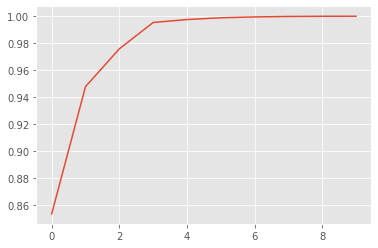

In [10]:
# Plot the variance explained graph
expl=pca.explained_variance_ratio_
cdf=[sum(expl[:i+1]) for i in range(len(expl))]
plt.plot(range(len(expl)), cdf);

In [11]:
# See the values from the above plot
cdf[:5]

[0.8532265203729359,
 0.947707220214131,
 0.9757804306422578,
 0.9953523989464002,
 0.9975449587767293]

From the above plot it can be seen that with just the first two Principal Components 97.6% of the variance is explained. That way the accesability features can be reduced into two variables that will be used in the machine learning models.

In [12]:
# Add the new PCA columns to the dataset
pca2 = decomposition.PCA(n_components=2)
new_acc_cols = pd.DataFrame(pca2.fit_transform(data_scaled))

In [13]:
# Rename the columns
new_acc_cols = new_acc_cols.rename(columns = {0:'acc_1', 1:'acc_2'})

In [14]:
# Create the new dataset without the acc_cols but with the new_acc_cols
data = df_o[df_o.columns[~df_o.columns.isin(acc_cols)]].merge(new_acc_cols, left_index = True, right_index = True)

The same procedure can be done on the Point of Interest columns that were added from the additional dataset. 

In [15]:
# Collect the POIs columns together
poi_cols = ['Nearest_Restaurant_km', 'Nr_Restaurants_5km',
       'Nearest_School_km', 'Nr_Schools_5km', 'Nearest_Kindergarten_km',
       'Nr_Kindergartens_5km', 'Nearest_Pharmacy_km', 'Nr_Pharmacies_5km',
       'Nearest_Supermarket_km', 'Nr_Supermarkets_5km']

# Scale the dataset
data_scaled = pd.DataFrame(preprocessing.scale(df_o[poi_cols]),columns = poi_cols) 

# Apply PCA
pca=decomposition.PCA()
pca.fit(data_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

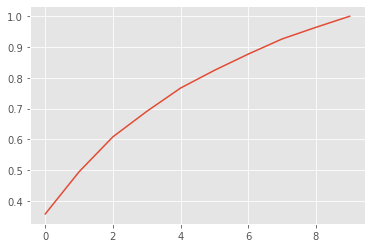

In [16]:
# Plot variance explained
expl=pca.explained_variance_ratio_
cdf=[sum(expl[:i+1]) for i in range(len(expl))]
plt.plot(range(len(expl)), cdf);

In [17]:
# Look at the values for the variance explained
cdf[:10]

[0.3578691326935681,
 0.4948674348272144,
 0.6083922162506563,
 0.6909074820210286,
 0.7666938841362552,
 0.8242373285159272,
 0.8769490353792813,
 0.9260980152368076,
 0.9639097849178482,
 0.9999999999999999]

From the above graph it can be seen that the columns give us additional information, so in order to explain more than 95% of the variance, the first 9 Principal Components would have to be used. Since the number of attributes is 10, the reduction in the number of features would be rather insignificant. Therefore all of the POI columns will be used in the modelling.

## 4. Create train/test split and standardize

Based on the information from the **Descriptive Statistics Notebook** it is already known that the test/train division based on the coordinates will be problematic. The test set covers the city center and therefore isn't represented in the best possible way by the training set, so it might cause some issues in the predictions. However, this split will be used since it was specified in the challenge description.

The features and target variable are defined based on the observations in the **Descriptive Statistics Notebook**. Then the test/train sets are standardized so that they would be ready for use in the modelling.

In [18]:
# Split the data into test/train set
test = data[(data.Longitude <= -70.6) &(data.Longitude >= -70.7) &(data.Latitude <= -33.4) & (data.Latitude >= -33.5)]
train = data[(data.Longitude > -70.6)|(data.Longitude < -70.7)|(data.Latitude > -33.4) | (data.Latitude < -33.5)]

In [19]:
# Print info
print('Test data length:', len(test))
print('Train data length:',len(train))
print('Sum:', len(test)+len(train))
print('Test % of whole dataset:', len(test)/(len(test)+len(train)))

Test data length: 2691
Train data length: 13692
Sum: 16383
Test % of whole dataset: 0.16425563083684308


In [20]:
# Look at the first few lines in the dataset
data.head()

,Hogar,Sector,DirCoordX,DirCoordY,MontoArr,IngresoHogar,Factor,AnosEstudio,CLASE,Sup_Prom_Constr_Hab_EOD,...,Nearest_School_km,Nr_Schools_5km,Nearest_Kindergarten_km,Nr_Kindergartens_5km,Nearest_Pharmacy_km,Nr_Pharmacies_5km,Nearest_Supermarket_km,Nr_Supermarkets_5km,acc_1,acc_2
0,100010,7,335180.8019,-3733579.025,100000,450845,136.393738,11,1,53.8,...,0.428810,3,3.291016,1,0.401852,3,0.382922,2,5.359134,1.297806
1,100020,7,338410.2114,-3734392.859,120000,1019369,73.843597,11,1,59.6,...,0.441469,3,0.931185,2,0.545372,2,0.641999,2,5.359134,1.297806
2,100030,7,327863.8248,-3742199.914,70000,80000,180.722809,10,1,59.5,...,7.423389,0,7.173717,0,11.434518,0,7.192890,0,5.359134,1.297806
3,100041,7,327864.0000,-3742200.000,80000,559259,150.379059,14,2,59.5,...,7.423479,0,7.173814,0,11.434464,0,7.192984,0,5.359134,1.297806
4,100052,7,338480.8152,-3732703.059,117771,710309,122.001518,12,2,43.6,...,0.765914,5,0.077181,2,1.161782,4,0.880952,2,5.359134,1.297806


In [21]:
X_cols = ['MontoArr', 'Sup_Prom_Constr_Hab_EOD', 'Calid_EOD_norm_inv', 'DensConstr_EOD',
          'Tiempo_Com_Stgo', 'Ingreso_Promedio_Zona_MM', 'acc_1','acc_2',
         'Nearest_Restaurant_km', 'Nr_Restaurants_5km',
       'Nearest_School_km', 'Nr_Schools_5km', 'Nearest_Kindergarten_km',
       'Nr_Kindergartens_5km', 'Nearest_Pharmacy_km', 'Nr_Pharmacies_5km',
       'Nearest_Supermarket_km', 'Nr_Supermarkets_5km']

#X_cols = X_cols.extend(poi_cols)
Y_col = ['CLASE']

In [22]:
#creating training and test sets
X_train = train[X_cols]
y_train = train[Y_col]
X_test = test[X_cols]
y_test = test[Y_col]

#standardizing training and test sets
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

## 5. Define functions predicting and evaluating predictions
In order to be able to evaluate the performance of the machine learning models the following functions are defined. 
The function **evaluate** evaluates and prints the performance of the model. The function **plot_confusion_matrix** plots the confusion matrix, showing a matrix of the actual vs. predicted classes, that highlights where the model is going wrong.

In [23]:
###### copied from Nuts and bolts of ML (lecture 7) #####
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

# function to evaluate predictions
def evaluate(y_true, y_pred, print_cm=False):
    # calculate and display confusion matrix
    labels = np.unique(y_true)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if print_cm:
        print('Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels')
        print(cm)

    # calculate precision, recall, and F1 score
    accuracy = float(np.trace(cm)) / np.sum(cm)
    precision = precision_score(y_true, y_pred, average=None, labels=labels)[1]
    recall = recall_score(y_true, y_pred, average=None, labels=labels)[1]
    f1 = 2 * precision * recall / (precision + recall)
    print("accuracy:", accuracy)
    print("precision:", precision)
    print("recall:", recall)
    print("f1 score:", f1)
    return[accuracy, precision, recall, f1]

In [24]:
####### Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html #######
# plotting the confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred,
                          title=None,
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    #print(cm)
    
    classes = ['CLASE 1','CLASE 2', 'CLASE 3']

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## 6. Testing different models for prediction

There are multiple different models that can be used for a classification probelm. In this case, the target variable has three possible classes. First a baseline model is defined, so that the other models can be compared to that. The accuracy measures for each model are combined in a results-dataframe for easier comparison. 

### Baseline model: Logistic Regression
The model chosen as the baseline is logistic regression with l2-regulazation. It's important to fight against overfitting, since we know that the training set and test set are quite different.

In [25]:
from sklearn.linear_model import LogisticRegression

# estimate model on trainset
lr = LogisticRegression(random_state=42, C = 0.1)
lr.fit(X_train, y_train)

# make predictions
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

print("- Train set results:")
lr_train_results = evaluate(y_train, y_pred_train, print_cm = False)
print("- Test set results:")
lr_test_results = evaluate(y_test, y_pred_test, print_cm = False)

- Train set results:
accuracy: 0.5712094653812445
precision: 0.537463976945245
recall: 0.5519565932259125
f1 score: 0.5446138870863076
- Test set results:
accuracy: 0.5031586770717206
precision: 0.47567114093959734
recall: 0.48091603053435117
f1 score: 0.47827920708561794


/Users/kristin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kristin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kristin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


As expected, the results on the test set are worse than the results on the training set. In addition, we can see that the accuarcy even on the training set is quite low, below 60%. Let's create a dataframe for storing all the results, so that it's easier to compare them in the end.

In [26]:
#creating a new dataframe for the results
results = pd.DataFrame(['accuracy', 'precision', 'recall', 'f1_score'])

In [27]:
#adding the results of the baseline model to the dataframe
results['LogReg-train-l2'] = lr_train_results
results['LogReg-test-l2'] = lr_test_results
results = results.set_index(0)

Let's have a look at the confusion matrix for the baseline model.

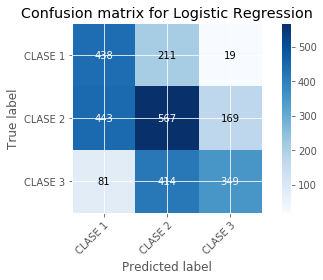

In [28]:
plot_confusion_matrix(y_test, y_pred_test, title = 'Confusion matrix for Logistic Regression');

From the confusion matrix we can see that the model predicts CLASE 1 quite well, since the majority get the correct label. In the case of CLASE 2 and CLASE 3, in over half of the cases the predicted label is wrong. Let's have a look at the coefficients of the features to gain a better understanding of the model. Because CLASE has three possible values, each class has a coefficient vector. For CLASE 1 the coefficients are presented below.

In [29]:
#lets examine the coefficients
print('Coefficients for CLASE 1')
for cname, val in zip(X_train.columns, lr.coef_.tolist()[0]):
    print("%s=%.3f"%(cname, val))

Coefficients for CLASE 1
MontoArr=-0.932
Sup_Prom_Constr_Hab_EOD=-0.023
Calid_EOD_norm_inv=0.008
DensConstr_EOD=-0.056
Tiempo_Com_Stgo=0.011
Ingreso_Promedio_Zona_MM=-0.659
acc_1=-0.026
acc_2=-0.015
Nearest_Restaurant_km=-0.026
Nr_Restaurants_5km=0.077
Nearest_School_km=0.093
Nr_Schools_5km=0.050
Nearest_Kindergarten_km=-0.028
Nr_Kindergartens_5km=-0.037
Nearest_Pharmacy_km=-0.027
Nr_Pharmacies_5km=0.035
Nearest_Supermarket_km=0.038
Nr_Supermarkets_5km=-0.001


In [30]:
print('MontoArr coefficient for CLASE 1:', lr.coef_.tolist()[0][0])
print('MontoArr coefficient for CLASE 2:', lr.coef_.tolist()[1][0])
print('MontoArr coefficient for CLASE 3:', lr.coef_.tolist()[2][0])

MontoArr coefficient for CLASE 1: -0.9318229956660335
MontoArr coefficient for CLASE 2: -0.007496634166508495
MontoArr coefficient for CLASE 3: 0.7734507894464684


From the coefficients of CLASE 1, we can see that MontoArr, i.e. the rent of the property, has the biggest coefficient in absolute value. To understand the effect of MontoArr on the results, we have to examine the coefficients for each category separately. Having a negative coefficient means that the event becomes more unlikely when the feature increases. This makes sense, because CLASE 1 includes the households with the lowest level of education, so they might have a lower salary and be less likely to afford a house with a high rent. For CLASE 3 the effect is the opposite.

### Model 2: Logistic regression with l1 regulizer
Next we will try to use logistic regression with the l1 regulizer. Here the goal is to give weights of 0 for the irrelevant features. 

In [31]:
# estimate model on trainset
lr2 = LogisticRegression(random_state=42, C = 0.1, penalty = 'l1')
lr2.fit(X_train, y_train)

# make predictions
y_pred_train = lr2.predict(X_train)
y_pred_test = lr2.predict(X_test)

print("- Train set results:")
results['LogReg-train-l1'] = evaluate(y_train, y_pred_train, print_cm = False)
print("- Test set results:")
results['LogReg-test-l1'] = evaluate(y_test, y_pred_test, print_cm = False)

- Train set results:
accuracy: 0.5713555360794624
precision: 0.5373517152933632
recall: 0.5511344952318317
f1 score: 0.5441558441558441
- Test set results:
accuracy: 0.49498327759197325
precision: 0.4710526315789474
recall: 0.455470737913486
f1 score: 0.463130659767141


/Users/kristin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kristin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kristin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


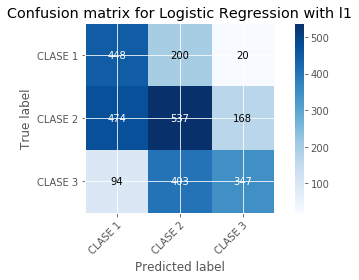

In [32]:
plot_confusion_matrix(y_test, y_pred_test, title = 'Confusion matrix for Logistic Regression with l1');

The results seem quite similar to the baseline model. Let's see which features were deemed irrelevant by the model for each CLASE.

In [33]:
#Lets check which features are irrelevant
for i in range(len(lr2.coef_)):
    print('Features of CLASE', i+1)
    for j in range(len(X_cols)):
        if lr2.coef_[i][j] == 0:
            print("Feature %s is irrelevant" % (X_cols[j],))
    print('')

Features of CLASE 1
Feature Nr_Supermarkets_5km is irrelevant

Features of CLASE 2
Feature Nearest_Pharmacy_km is irrelevant

Features of CLASE 3
Feature DensConstr_EOD is irrelevant
Feature acc_1 is irrelevant
Feature Nearest_Pharmacy_km is irrelevant
Feature Nr_Pharmacies_5km is irrelevant



### Model 3: Support Vector Machines
Let's next try to use support vector machines to predict the labels. The goal of support vector machines is the maximize the separation margin between the classes. 

In [34]:
from sklearn.svm import SVC
sv = SVC()

sv.fit(X_train, y_train)

y_pred_train = sv.predict(X_train)
y_pred_test = sv.predict(X_test)

print("- Train set results:")
results['SVC-train'] = evaluate(y_train, y_pred_train, print_cm = False)
print("- Test set results:")
results['SVC-test'] = evaluate(y_test, y_pred_test, print_cm = False)

/Users/kristin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kristin/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


- Train set results:
accuracy: 0.6067046450482033
precision: 0.5706291591046582
recall: 0.6203551463334429
f1 score: 0.5944540727902946
- Test set results:
accuracy: 0.5180230397621702
precision: 0.4892904953145917
recall: 0.620016963528414
f1 score: 0.5469509913954359


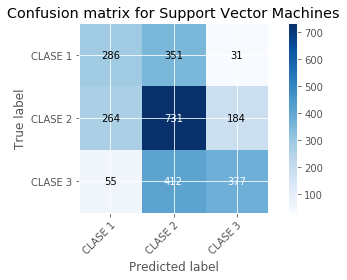

In [35]:
plot_confusion_matrix(y_test, y_pred_test, title = 'Confusion matrix for Support Vector Machines');

The results on the total level seem slightly better than the baseline. When we look at the correlation matrix, we can see some problems. CLASE 2 is predicted very well, but for the majority (i.e. over a half of the cases) of CLASE 1 the model predicts CLASE 2, and for the majority of CLASE 3 the model also predicts CLASE 2. Support vector machines can be difficult to use in modelling if the data is not linearly separable, and having such high dimensions as we do, it can be difficult to find the correct separation vectors.

### Model 4: KNeighbors classifier
Instead of trying to find vectors to separate the classes, let's see if finding similar points with KNeighbors classifier. 

In [36]:
from sklearn.neighbors import KNeighborsClassifier
kn = KNeighborsClassifier(n_neighbors=40)

kn.fit(X_train, y_train)

y_pred_train = kn.predict(X_train)
y_pred_test = kn.predict(X_test)

print("- Train set results:")
results['KNN-train'] = evaluate(y_train, y_pred_train, print_cm = False)
print("- Test set results:")
results['KNN-test'] = evaluate(y_test, y_pred_test, print_cm = False)

/Users/kristin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


- Train set results:
accuracy: 0.5893222319602688
precision: 0.5636947791164658
recall: 0.5769483722459717
f1 score: 0.5702445762574144
- Test set results:
accuracy: 0.5187662578966927
precision: 0.51252408477842
recall: 0.45122985581000846
f1 score: 0.4799278304014434


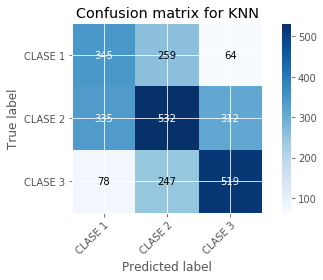

In [37]:
plot_confusion_matrix(y_test, y_pred_test, title = 'Confusion matrix for KNN');

The KNN model seems to have a a slightly better accuracy compared to the baseline. From the confusion matrix we can see that the classification of CLASE 3 has improved, so that the majority of the predictions are accurate. For CLASE 1 slightly over 50% of predictions are correct. However, for CLASE 2 the predicted labels are wrong in over half of the cases.

### Model 4: Random forest
The next model we will test is a random forest. A random forest is a system of k decision trees that have been built based on k subsets of the dataset. For prediction, the whole forest is used and the output is decided based on the majority.

In [38]:
from sklearn.ensemble import RandomForestClassifier
k=8
rf = RandomForestClassifier(n_estimators =k )

rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

print("- Train set results:")
results['RandomForest-train'] = evaluate(y_train, y_pred_train, print_cm = False)
print("- Test set results:")
results['RandomForest-test'] = evaluate(y_test, y_pred_test, print_cm = False)

/Users/kristin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


- Train set results:
accuracy: 0.9671340929009641
precision: 0.9740759324301723
recall: 0.9575797435054259
f1 score: 0.9657573998839233
- Test set results:
accuracy: 0.4845782237086585
precision: 0.49536178107606677
recall: 0.4529262086513995
f1 score: 0.4731945059813912


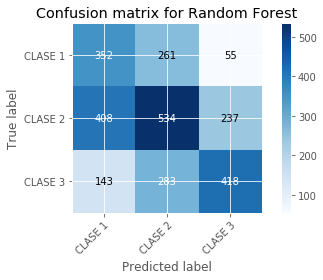

In [39]:
plot_confusion_matrix(y_test, y_pred_test, title = 'Confusion matrix for Random Forest');

The random forest works exceptionally well on the training set, which is expected. However, the results on the training sets are worse than for the baseline. Looking at the confusion matrix we can see that not even one of the CLASEs is getting accurate predictions. Let's have a look at the feature importances in the random forest.

In [40]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair))

Variable: MontoArr             Importance: 0.11
Variable: Ingreso_Promedio_Zona_MM Importance: 0.08
Variable: Nearest_School_km    Importance: 0.08
Variable: Nearest_Kindergarten_km Importance: 0.08
Variable: Nearest_Supermarket_km Importance: 0.08
Variable: acc_1                Importance: 0.07
Variable: acc_2                Importance: 0.07
Variable: Nearest_Restaurant_km Importance: 0.07
Variable: Nearest_Pharmacy_km  Importance: 0.07
Variable: DensConstr_EOD       Importance: 0.05
Variable: Sup_Prom_Constr_Hab_EOD Importance: 0.04
Variable: Nr_Restaurants_5km   Importance: 0.04
Variable: Nr_Schools_5km       Importance: 0.04
Variable: Calid_EOD_norm_inv   Importance: 0.03
Variable: Tiempo_Com_Stgo      Importance: 0.03
Variable: Nr_Kindergartens_5km Importance: 0.03
Variable: Nr_Pharmacies_5km    Importance: 0.03
Variable: Nr_Supermarkets_5km  Importance: 0.02


MontoArr seems to be the most important variable in the random forest, which is in line with the observations made from logstic regression coefficients. 

### Model 5: Neural network
The last model we will try is a neural network. Because there are three target classes, we have to do some data preparation before modelling. This example was used as a reference: https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

In [41]:
from keras.utils import np_utils

Using TensorFlow backend.


In [42]:
#creating a target dummy vector
uniques_train, ids_train = np.unique(y_train, return_inverse=True)
uniques_test, ids_test = np.unique(y_test, return_inverse=True)

y_train_dummy = np_utils.to_categorical(ids_train, len(uniques_train))
y_test_dummy = np_utils.to_categorical(ids_test, len(uniques_test))

In [43]:
#how to reverse back from dummy vector to actual values of CLASE
y_train_dummy.argmax(1)+1

array([1, 1, 1, ..., 3, 1, 1])

The next step is to create a neural network. We will use quite a simple structure but include l2 regularizers in all the layers to combat overfitting. 

In [44]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers

In [45]:
# function to fit nnet
def fit_nnet(X_train, y_train, num_epochs=15, batch_size=100):
    # define the keras model
    model = Sequential()
    model.add(Dense(150, input_dim=18, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(30, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.0001)))

    # compile the keras model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit the keras model on the dataset
    history = model.fit(X_train, y_train, validation_split = 0.3,
                        epochs=num_epochs, batch_size=batch_size, verbose=2)
    return model, history

In [46]:
def eval_nnet(model, X_new, y_true):
    # evaluate the keras model
    y_pred = model.predict(X_new)
    y_pred = (y_pred > 0.5).astype(int)
    y_pred = y_pred.argmax(1)+1

    # evaluate predictions
    result = evaluate(y_true, y_pred)
    return y_pred, result

In [47]:
fitted_model, history = fit_nnet(X_train, y_train_dummy)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 9584 samples, validate on 4108 samples
Epoch 1/15
 - 1s - loss: 0.9136 - acc: 0.5391 - val_loss: 0.8841 - val_acc: 0.5445
Epoch 2/15
 - 0s - loss: 0.8651 - acc: 0.5775 - val_loss: 0.8737 - val_acc: 0.5543
Epoch 3/15
 - 0s - loss: 0.8532 - acc: 0.5886 - val_loss: 0.8755 - val_acc: 0.5592
Epoch 4/15
 - 0s - loss: 0.8480 - acc: 0.5888 - val_loss: 0.8711 - val_acc: 0.5626
Epoch 5/15
 - 0s - loss: 0.8443 - acc: 0.5888 - val_loss: 0.8800 - val_acc: 0.5565
Epoch 6/15
 - 0s - loss: 0.8375 - acc: 0.5962 - val_loss: 0.8714 - val_acc: 0.5735
Epoch 7/15
 - 0s - loss: 0.8324 - acc: 0.5980 - val_loss: 0.8654 - val_acc: 0.5723
Epoch 8/15
 - 0s - loss: 0.8285 - acc: 0.6012 - val_loss: 0.8728 - val_acc: 0.5723
Epoch 9/15
 - 0s - loss: 0.8233 - acc: 0.6064 - val_loss: 0.8714 - val_acc: 0.5706
Epoch 10/15
 - 0s - loss: 0.8211 - acc: 0.6055 - val_loss: 0.8745 - val_acc: 0.5694
Epoch 11/15
 - 0s - l

In [48]:
print("- Train set results:")
y_pred_train, results['NN-train-reg']  = eval_nnet(fitted_model, X_train, y_train)
print("- Test set results:")
y_pred_test, results['NN-test-reg'] = eval_nnet(fitted_model, X_test, y_test)

- Train set results:
accuracy: 0.5901986561495763
precision: 0.6171980242478671
recall: 0.4519894771456758
f1 score: 0.5218299164768413
- Test set results:
accuracy: 0.432924563359346
precision: 0.488
recall: 0.3621713316369805
f1 score: 0.4157740993184031


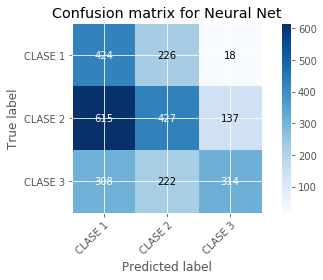

In [49]:
plot_confusion_matrix(y_test, y_pred_test, title = 'Confusion matrix for Neural Net');

The accuracies are similar to the previous models. In terms of the correlation matrix, we can see that the model has trouble especially in predicting CLASE 3, but also CLASE 1. In the case of CLASE 2, the majority of predictions are accurate.

## 7. Comparing the results of the different models
Now we have all the results in the results dataframe. Let's modify the dataframe a bit and then compare all of the models to find the model that has the best performance according to our evaluation metrics. 

In [50]:
#let's transpose the dataframe and create a new column to distinguish between train and test results

results_t = results.T
results_t.reset_index(inplace=True)
results_t['test'] = results_t['index'].apply(lambda s: 1 if 'test' in s else 0)
results_t.set_index('index', drop=True, inplace=True)
results_t

,accuracy,precision,recall,f1_score,test
index,,,,,
LogReg-train-l2,0.571209,0.537464,0.551957,0.544614,0
LogReg-test-l2,0.503159,0.475671,0.480916,0.478279,1
LogReg-train-l1,0.571356,0.537352,0.551134,0.544156,0
LogReg-test-l1,0.494983,0.471053,0.455471,0.463131,1
SVC-train,0.606705,0.570629,0.620355,0.594454,0
SVC-test,0.518023,0.489290,0.620017,0.546951,1
KNN-train,0.589322,0.563695,0.576948,0.570245,0
KNN-test,0.518766,0.512524,0.451230,0.479928,1
RandomForest-train,0.967134,0.974076,0.957580,0.965757,0


In [51]:
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)

results_t[results_t.test == 1].style.background_gradient(cmap=cm)

0,accuracy,precision,recall,f1_score,test
index,,,,,
LogReg-test-l2,0.503159,0.475671,0.480916,0.478279,1
LogReg-test-l1,0.494983,0.471053,0.455471,0.463131,1
SVC-test,0.518023,0.48929,0.620017,0.546951,1
KNN-test,0.518766,0.512524,0.45123,0.479928,1
RandomForest-test,0.484578,0.495362,0.452926,0.473195,1
NN-test-reg,0.432925,0.488,0.362171,0.415774,1


According to the accuracy metrics, SVC gives the best accuracy on the test set. From the confusion matrix we saw that the model predicts CLASE 2 most often, and the accuracy is therefore good for CLASE 2 observations, which is the most common category. The neural network has the second highest recall score and is able to predict CLASE 2 quite well, but again has difficulties in predicting the two smaller categories.

It could be argued that the best model to use is KNN. The KNN model has the second best accuracy, and seems to give fairly accurate predictions for CLASE 1 and CLASE 2. The model has some difficulties predicting the middle class, i.e. CLASE 2, but the number of correct labels is still higher than the number of either of the wrong labels. 

## 8. Testing predictions with a shuffled dataset
One reason for the bad accuracy on the test set is probably the division between train and test sets. As mentioned before, the train and test sets are very different, so let's try to create a random train/test split and use a few of the models to see if we can get better results. The random forest has an excellent accuracy on the training set, so using that model on a shuffled dataset might give us good results.

In [52]:
from sklearn.model_selection import train_test_split
X= data[X_cols]
y = data[Y_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#standardizing training and test sets
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train = (X_train - X_mean) / X_std
#X_val = (X_val - X_mean) / X_std
X_test = (X_test - X_mean) / X_std


In [53]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 10)

rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

print("- Train set results:")
evaluate(y_train, y_pred_train, print_cm = False)
print("- Test set results:")
evaluate(y_test, y_pred_test, print_cm = False)

/Users/kristin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


- Train set results:
accuracy: 0.9764993132916222
precision: 0.9775862068965517
recall: 0.9728894989704873
f1 score: 0.9752321981424148
- Test set results:
accuracy: 0.5337198657308514
precision: 0.5016903313049358
recall: 0.5177948360083741
f1 score: 0.5096153846153847


[0.5337198657308514,
 0.5016903313049358,
 0.5177948360083741,
 0.5096153846153847]

The results for the test set didn't improve as much as hoped, and there still seems to be a mismatch between the training and the test sets. It seems like the random forest is overfitting on our training set, but even decreasing the number of trees doesn't seem to decrease overfitting and increase the accuracy on the test set. It seems like the features we have just don't have a great predictive power. 

Let's try to use the SVC for the shuffled dataset, since that seemed to have the highest accuracy. 

In [54]:
from sklearn.svm import SVC
sv = SVC()

sv.fit(X_train, y_train)

y_pred_train = sv.predict(X_train)
y_pred_test = sv.predict(X_test)

print("- Train set results:")
evaluate(y_train, y_pred_train, print_cm = False)
print("- Test set results:")
evaluate(y_test, y_pred_test, print_cm = False)

/Users/kristin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kristin/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


- Train set results:
accuracy: 0.6074317106668702
precision: 0.56957583155325
recall: 0.640528483184626
f1 score: 0.6029720562106283
- Test set results:
accuracy: 0.5898687824229478
precision: 0.5388207822533567
recall: 0.6441032798325191
f1 score: 0.5867768595041322


[0.5898687824229478,
 0.5388207822533567,
 0.6441032798325191,
 0.5867768595041322]

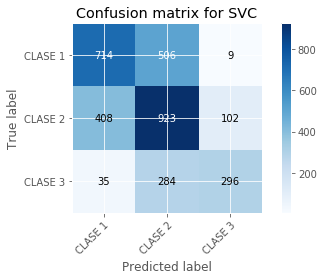

In [55]:
plot_confusion_matrix(y_test, y_pred_test, title = 'Confusion matrix for SVC');

The results for the test and train sets are now closer to each other, as expected. The confusion matrix actually looks fairly good, as the majority of CLASE 1 and CLASE 2 get the correct labels. There are still some difficulties in predicting the label for CLASE 3, and the overall results are still just below 60%. Even though we specifically chose features that have the highest correlation with the target varible, the features still don't seem to explain the target variable in the best possible way. To improve results further, we would need to get access to variables that have a higher explanatory value. 

## 9. Conclusions

The results show that it is difficult to predict the CLASE accurately, especially when the training set and test set are of different areas and therefore perform in a different way. As we saw in the Descriptive Statistics Notebook, the test set covers the city center. In the city center for example the distances have a different meaning because everything is close by. For example a 1km distance to the closes grocery store can be quite a long distance, while somewhere in the suburbs 1km could be considered short. This kind of distrotion in values is not taken into account in the modeling. 

Even the results on the training set seemed to be quite low, as the accuracy was around 60%. This might be due to the fact that the features we have are simply not explanatory enough. The dataset would need to be enriched with more relevant features in order to make more accurate predictions. Another way to look at the problem is the target variable definition - is it sufficient to expect that the kind of house depends on years of education? A more natural measure would be the household income, the size of the household, the number of kids in the household or the average age of the household - or a combination of these. Formulating the problem in a logical way and thinking critically what we want to predict is an extremely important part of a data scientist's job. 

## 10. Division of work

In [56]:
notebooks = ['1. Descriptive statistics', '2. Additional dataset', '3. Exploratory part', '4. Predictive part']
workload_1 = {'Petra': 0.33, 'Lukas': 0.33, 'Kristin': 0.33}
workload_2 = {'Petra': 0, 'Lukas': 0, 'Kristin': 1}
workload_3 = {'Petra': 0, 'Lukas': 0.85, 'Kristin': 0.15}
workload_4 = {'Petra': 0.9, 'Lukas': 0, 'Kristin': 0.1}

In [57]:
workloads = [workload_1, workload_2, workload_3, workload_4]
for i in range(4):
    print('Workload division for:', notebooks[i])
    for part in workloads[i]:
        print (part,':', workloads[i][part])
    print("")

Workload division for: 1. Descriptive statistics
Petra : 0.33
Lukas : 0.33
Kristin : 0.33

Workload division for: 2. Additional dataset
Petra : 0
Lukas : 0
Kristin : 1

Workload division for: 3. Exploratory part
Petra : 0
Lukas : 0.85
Kristin : 0.15

Workload division for: 4. Predictive part
Petra : 0.9
Lukas : 0
Kristin : 0.1

